## Instructions

Goal: Your task is to build the best possible model to predict defaulted firms in the ‘Manufacture of
computer, electronic and optical products’ industry, 2015.

#### Hold-out sample

To construct the hold-out sample, follow, the next specification:
- Your definition of default should be the following:
 Existed in 2014 (sales > 0), but did not exists in 2015 (sales is 0 or missing)
- We are only interested in predicting default for ‘ind2 == 26’, which is the selected industry, and the
firm is a small or medium enterprise (SME). Thus, yearly sales in 2014 was between 1000 EUR and 10
million EUR.
- If you do the sample design properly, you have an overall of 1037 firms. 56 firms defaulted, and 981
stayed alive. The average sales of the firms is 0.4902 million EUR, with the minimum of 0.00107 million
EUR and 9.57648 million EUR.
- You should not use this sample for modeling, only for your final prediction’s evaluation. If you use
these data in any (visible) way to estimate a model, you will be penalized with -10 points. You should
report your final model of choice’s following measures on this hold-out sample:
    - Brier-score
    - ROC curve
    - AUC
    - Accuracy, sensitivity, specificity (for optimal threshold)
    - Expected loss and optimal threshold
        - Expected loss is has the following parameters: loss(F N) = 15, loss(F P) = 3
    - In addition, report the same descriptive statistics: number of firms, firms defaulted and stayed
alive. Mean of sales, minimum and maximum values. This helps our work to evaluate and compare
your results.

#### Task
- Build the best prediction to classify the defaults.
- You may do different feature engineering.
- You may make any sample design decisions!
- In each case, document your steps!
- Have at least 3 different models and compare performance
- Argue for your choice of models
    - One model must be theoretically profound logistic regression.
    - You can use any model you wish, even models that we have not covered in this course.

### SUBMISSION

- A summary report (pdf), max 3 pages including tables and graphs discussing your work. It is targeted at data science team leaders
    - Can use technical language
    - But need to be the point
    - Focus on key decision points, results, interpretation, decision
- Technical report – a markdown / quarto in pdf/html with more technical discussion.
    - May include code snippets
    - May include additional tables and graphs
    - Detail all decisions you made
- Reports should link to code in Git Hub

### Scoring weights
Overall, you can get 30p from this task.
- It is a prediction race. 15 points will be allocated according to model performance compared to your
peers.
    - You should aim to get the lowest expected loss value.
    - Best gets 15 points; remaining is scaled as a distance from the closest.
- The remaining 15 points can be earned for the following:
    - Data prep, label, and feature engineering (5p)
    - Model building, prediction, and model selection (5p)
    - Discussion of steps, decisions, and results (3p)
    - Quality of the write-up (2p)
Submission deadline: 3rd of March, 2024, 23.59 CET

## Introduction
In this project we are going to predict corporate exit. We are going to predict the probability of firm exit and classify firms into prospective exiting firms and prospective staying in business firms. We are going to use `bisnode-firms` dataset. The data was collected and cleaned by Bisnode, a major European business information company.

We will focus on companies in manufacturing electronic products. Using data prior to 2015 we will use to train and then test if companies stayed in the business in 2015.

We don't have exact y variable for exiting, but we will consider one like if the company had sales >0 in 2014 and didn't exist in 2015 or sales was 0 or missing. So in that case our y is going to be 1, otherwise 0.



In [465]:
import os
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from py_helper_functions import *

import warnings
warnings.filterwarnings('ignore')

In [388]:
# helper functions

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(size=0.7) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)), angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

### Initial Setup

In [314]:
# read the data
raw_data = pd.read_csv("https://osf.io/download/3qyut/")
# show the first 2 rows
raw_data.head(2)

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,net_dom_sales,net_exp_sales,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,wages,D,balsheet_flag,balsheet_length,balsheet_notfullyear,year,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,NaN,1229.629639,218.518524,0.0,4355.555664,2911.111084,38222.222656,NaN,NaN,22222.222656,62.962963,62751.851562,881.481506,1388.888916,1229.629639,NaN,NaN,0,364,0,2005,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,NaN,725.925903,996.296326,0.0,7225.925781,5896.296387,38140.742188,NaN,NaN,23844.445312,755.555542,64625.925781,1637.036987,1388.888916,725.925903,NaN,NaN,0,364,0,2006,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN


### Form Holdout set

In [315]:
raw_data.shape
raw_data.columns

Index(['comp_id', 'begin', 'end', 'COGS', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'finished_prod',
       'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories',
       'liq_assets', 'material_exp', 'net_dom_sales', 'net_exp_sales',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'wages', 'D', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year',
       'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind',
       'urban_m', 'region_m', 'founded_date', 'exit_date', 'labor_avg'],
      dtype='object')

In [316]:
raw_data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,net_dom_sales,net_exp_sales,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,wages,D,balsheet_flag,balsheet_length,balsheet_notfullyear,year,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,NaN,1229.629639,218.518524,0.0,4355.555664,2911.111084,38222.222656,NaN,NaN,22222.222656,62.962963,62751.851562,881.481506,1388.888916,1229.629639,NaN,NaN,0,364,0,2005,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,NaN,725.925903,996.296326,0.0,7225.925781,5896.296387,38140.742188,NaN,NaN,23844.445312,755.555542,64625.925781,1637.036987,1388.888916,725.925903,NaN,NaN,0,364,0,2006,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,NaN,1322.222168,570.370361,0.0,7951.852051,177.777771,40174.074219,NaN,NaN,22262.962891,0.000000,65100.000000,1633.333374,1388.888916,1322.222168,NaN,NaN,0,364,0,2007,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,NaN,1022.222229,714.814819,0.0,5233.333496,1392.592651,54274.074219,NaN,NaN,21107.408203,0.000000,78085.187500,1725.925903,1481.481445,1022.222229,NaN,NaN,0,365,0,2008,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,NaN,814.814819,-11044.444336,0.0,3259.259277,11.111111,41755.554688,NaN,NaN,13237.037109,-11074.074219,45388.890625,-9348.148438,1481.481445,814.814819,NaN,NaN,0,364,0,2009,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [317]:
# Filter for eligible firms in 2014 within the specified industry and sales range.
eligible_firms_2014 = raw_data[(raw_data['year'] == 2014) & (raw_data['ind2'] == 26) & (raw_data['sales'] >= 1000) & (raw_data['sales'] <= 10000000)]

# Identify firms in 2015 to check their status.
firms_2015 = raw_data[(raw_data['year'] == 2015) & (raw_data['ind2'] == 26)]

# Determine which of the eligible firms from 2014 stayed alive in 2015 by having sales > 0.
stayed_firms = firms_2015[firms_2015['comp_id'].isin(eligible_firms_2014['comp_id']) & (firms_2015['sales'] > 0)]

# Determine defaulted firms as those who were present in 2014 but not in 2015 or had sales = 0 in 2015.
defaulted_firms = eligible_firms_2014[~eligible_firms_2014['comp_id'].isin(stayed_firms['comp_id'])]

# Counts
num_stayed = stayed_firms['comp_id'].nunique()  # Ensure unique firms are counted once
num_defaulted = defaulted_firms['comp_id'].nunique()

# print the counts of firms that stayed alive and defaulted in 2015 for the companies that operated in 2014
print(f"Number of firms that stayed alive: {num_stayed}")
print(f"Number of firms that defaulted: {num_defaulted}")


Number of firms that stayed alive: 981
Number of firms that defaulted: 56


### Cleaning and feature engineering

In [318]:
# display all rows
pd.set_option('display.max_rows', None)

In [319]:
# Check for missing values. Show all columns with missing values.
raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

In [320]:
raw_data.shape

(287829, 48)

In [321]:
# drop year 2016
df = raw_data[raw_data['year'] != 2016]
df.shape

(278086, 48)

In [322]:
# drop columns with more than 70% missing values
df = df.dropna(thresh=0.3*len(df), axis=1)
df.shape

(278086, 40)

In [323]:
# check the dropped columns
set(raw_data.columns) - set(df.columns)

{'COGS',
 'D',
 'exit_date',
 'exit_year',
 'finished_prod',
 'net_dom_sales',
 'net_exp_sales',
 'wages'}

In [324]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
df = (
    df.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
df = df.replace("toReplace", np.nan)

In [325]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
df["status_alive"] = (df["sales"] > 0 & (False == df["sales"].isna())).astype(int)

In [326]:
# default if there are sales in this year but no sales in the next year
df["default"] = (
    (df["status_alive"] == 1)
    & (df.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [327]:
# assets can't be negative. Change them to 0 and add a flag.
df["flag_asset_problem"] = np.where(
    (
        (df["intang_assets"] < 0)
        | (df["curr_assets"] < 0)
        | (df["fixed_assets"] < 0)
    ),
    1,
    0,
)
df["flag_asset_problem"] = np.where(
    (
        (df["intang_assets"].isna())
        | (df["curr_assets"].isna())
        | (df["fixed_assets"].isna())
    ),
    np.nan,
    df["flag_asset_problem"],
)
df.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    277723
1.0       223
Name: comp_id, dtype: int64

The dataset includes a process to ensure the integrity of asset data for each company. This process involves the following steps:

1. **Flagging Asset Problems**: A new column, `flag_asset_problem`, is introduced to flag companies with potential issues in their asset reports. A company is flagged (`flag_asset_problem` = 1) if it reports negative values in any of the following asset categories: intangible assets (`intang_assets`), current assets (`curr_assets`), or fixed assets (`fixed_assets`). This flag serves as an indicator of potential data quality issues that warrant further investigation.

2. **Handling Missing Data**: The process also accounts for missing asset data. If a company has any missing (NA) values in the aforementioned asset categories, the `flag_asset_problem` for that company is set to NaN. This distinction ensures that the flag specifically identifies known data quality issues, rather than penalizing companies for incomplete data records.

3. **Data Summary**: The dataset is then grouped by the `flag_asset_problem` status, and a count of companies within each category is generated. This summary provides insight into the prevalence of asset-related data issues across the dataset, distinguishing between actual problems and cases of missing data.


In [328]:
# Correct negative asset values to 0 for intangible, current, and fixed assets
df["intang_assets"] = np.where(df["intang_assets"] < 0, 0, df["intang_assets"])
df["curr_assets"] = np.where(df["curr_assets"] < 0, 0, df["curr_assets"])
df["fixed_assets"] = np.where(df["fixed_assets"] < 0, 0, df["fixed_assets"])

In [329]:
# generate total assets
df["total_assets_bs"] = (
    df["intang_assets"] + df["curr_assets"] + df["fixed_assets"]
)

This code snippet preprocesses the sales column in a DataFrame by first addressing negative sales values, converting sales to a more interpretable scale, and computing logarithmic transformations for further analysis. Specifically, any negative values in the sales column are corrected to 1, under the assumption that sales cannot be negative and to prepare for logarithmic transformation. This adjustment is essential as the logarithm of a negative number is undefined, and setting negative sales to 1 ensures the logarithm operation can proceed without error.

Following this, the code performs several transformations: it calculates the natural logarithm of sales (ln_sales), converting sales figures into their logarithmic scale to handle skewness in the data; it scales down sales figures to millions (sales_mil) for easier interpretation and analysis; and it computes the logarithm of the sales figures in millions (sales_mil_log). These steps are vital for data analysis and modeling, as they help normalize the distribution of sales figures, making patterns more discernible and statistical analyses more robust.

In [330]:
# Correct negative sales values to 1, compute log of sales, and scale sales to millions
df["sales"] = np.where(df["sales"] < 0, 1, df["sales"])  # Adjust negative sales values directly
df = df.assign(
    ln_sales=np.where(
        df["sales"] > 0,
        np.log(df["sales"]),  # Compute natural log of sales for positive sales values
        (np.where(df["sales"].isna(), np.nan, 0)),  # Keep NaN as NaN and set log(1) for corrected values to 0
    ),
    sales_mil=df["sales"] / 1000000,  # Scale sales figures down to millions
    sales_mil_log=np.where(
        df["sales"] > 0,
        np.log(df["sales"] / 1000000),  # Compute natural log of sales in millions for positive sales values
        (np.where(df["sales"].isna(), np.nan, 0)),  # Keep NaN as NaN and set log(1) for corrected values to 0
    ),
)


In [331]:
df.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,balsheet_flag,balsheet_length,balsheet_notfullyear,founded_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,labor_avg,status_alive,default,flag_asset_problem,total_assets_bs,ln_sales,sales_mil,sales_mil_log
0,2005,1001034.0,2005-01-01,2005-12-31,692.592590,7266.666504,7574.074219,0.0,0.000000,0.000000,1229.629639,218.518524,0.0,4355.555664,2911.111084,38222.222656,22222.222656,62.962963,62751.851562,881.481506,1388.888916,1229.629639,0.0,364.0,0.0,1990.0,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,1,0,0.0,8496.296143,11.046943,0.062752,-2.768567
1,2005,1001541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
2,2005,1002029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
3,2005,1003200.0,2005-01-01,2005-12-31,25.925926,729.629639,3803.703613,0.0,4814.814941,4814.814941,1166.666626,-1277.777832,0.0,225.925919,459.259247,10140.741211,6855.555664,-1277.777832,11118.518555,-11907.407227,1851.851807,1166.666626,0.0,364.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5630.0,56.0,3.0,1.0,Central,2003-10-21,NaN,1,0,0.0,1896.296265,9.316367,0.011119,-4.499143
4,2005,1004012.0,2005-01-01,2005-12-31,114.814812,1648.148193,3777.777832,0.0,0.000000,0.000000,0.000000,229.629623,0.0,0.000000,211.111115,1914.814819,3448.148193,229.629623,5833.333496,-2129.629639,74.074074,0.000000,0.0,364.0,0.0,1991.0,1.0,0.0,0.0,NaN,7722.0,male,Domestic,3314.0,33.0,2.0,3.0,West,1991-11-24,NaN,1,0,0.0,1648.148193,8.671344,0.005833,-5.144167


In [332]:
# Calculate year-over-year change in log-transformed sales (in millions) for each company
df["d1_sales_mil_log"] = df["sales_mil_log"] - df.groupby("comp_id")["sales_mil_log"].shift(1)


In [333]:
# Calculate the age of each firm by subtracting the founding year from the current year;
# set age to 0 for any negative values indicating df anomalies or new firms.
df["age"] = np.where(
    df["year"] - df["founded_year"] < 0, 0, df["year"] - df["founded_year"])

# Create a "new" indicator variable that flags firms as new (1) if their age is 1 or less,
# or if their balance sheet doesn't cover a full year; otherwise, set it to 0 or maintain NaN for missing age.
df["new"] = np.where(
    ((df["age"] <= 1) | (df["balsheet_notfullyear"] == 1)), 1, (np.where(df["age"].isna(), np.nan, 0)))

# For new firms (identified by the "new" column),
# set the year-over-year change in the logarithm of sales to 0 to avoid misleading calculations; maintain NaN where "new" is undefined.
df["d1_sales_mil_log"] = np.where(
    df["new"] == 1, 0, np.where(df["new"].isna(), np.nan, df["d1_sales_mil_log"]))

# Reevaluate the "new" flag for firms based on the availability of the year-over-year sales log change;
# if it's missing, consider the firm as new.
df["new"] = np.where(
    df["d1_sales_mil_log"].isna(), 1, df["new"])

# For firms without a year-over-year change in the sales log (likely new firms without prior year data),
# set the change to 0 to standardize the dataset.
df["d1_sales_mil_log"] = np.where(df["d1_sales_mil_log"].isna(), 0, df["d1_sales_mil_log"])

In [334]:
# Define P&L statement variable names for financial analysis
pl_names = ["extra_exp", "extra_inc", "extra_profit_loss", "inc_bef_tax", "inventories", "material_exp", "profit_loss_year", "personnel_exp"]

# Define balance sheet variable names for financial analysis
bs_names = ["intang_assets", "curr_liab", "fixed_assets", "liq_assets", "curr_assets", "share_eq", "subscribed_cap", "tang_assets"]

In [335]:
# Normalize selected P&L statement metrics by sales for comparative analysis
df[[col + "_pl" for col in pl_names]] = df[pl_names].div(df["sales"], axis="index")

# divide all bs_names elements by total_assets_bs and create new column for it
df[[col + "_bs" for col in bs_names]] = (
    df[bs_names]
    .div(df["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)

In [336]:
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    df[col + "_bs"] = np.where(
        df["total_assets_bs"].isna(), np.nan, df[col + "_bs"]
    )

This code block is designed to create flags for identifying outliers and errors in certain accounting variables and to apply winsorization to those variables. Winsorization is a statistical technique used to limit extreme values in the data to reduce the effect of possibly spurious outliers. Specifically, it involves replacing values beyond a certain threshold with values closer to the median or a specified percentile. Here's a detailed explanation of each part of the code:

In [337]:
# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

# Create flags for high values: 1 if > 1, NaN stays NaN
df[[col + "_flag_high" for col in zero]] = np.where(
    df[zero].isna(), np.nan, (df[zero] > 1).astype(int)
)

# Winsorize high values: cap at 1, preserving NaN
df[[col for col in zero]] = np.where(
    df[zero].isna(), np.nan, np.where(df[zero] > 1, 1, df[zero])
)

# Create flags for error values: 1 if < 0, NaN stays NaN
df[[col + "_flag_error" for col in zero]] = np.where(
    df[zero].isna(), np.nan, (df[zero] < 0).astype(int)
)

# Correct error values: set < 0 to 0, preserving NaN
df[[col for col in zero]] = np.where(
    df[zero].isna(), np.nan, np.where(df[zero] < 0, 0, df[zero])
)


In [338]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

df[[col + "_flag_low" for col in anyof]] = np.where(
    df[anyof].isna(), np.nan, (df[anyof] < -1).astype(int)
)
df[[col for col in anyof]] = np.where(
    df[anyof].isna(), np.nan, np.where((df[anyof] < -1), -1, df[anyof])
)
df[[col + "_flag_high" for col in anyof]] = np.where(
    df[anyof].isna(), np.nan, (df[anyof] > 1).astype(int)
)
df[[col for col in anyof]] = np.where(
    df[anyof].isna(), np.nan, np.where((df[anyof] > 1), 1, df[anyof])
)
df[[col + "_flag_zero" for col in anyof]] = np.where(
    df[anyof].isna(), np.nan, (df[anyof] == 0).astype(int)
)
df[[col + "_quad" for col in anyof]] = np.where(
    df[anyof].isna(), np.nan, df[anyof] ** 2
)

In [339]:
df.shape

(510532, 104)

Dropping additional columns

In [340]:
# dropping flags with no variation
flag_columns = [col for col in df.columns if "flag" in col]
df = df.drop(
    df[flag_columns].std()[(df[flag_columns].std() == 0)].index, axis=1
)

In [341]:
df.shape

(510532, 98)

Adding variables on CEO age

In [342]:
# Calculate CEO age by subtracting the birth year from the current year
df["ceo_age"] = df["year"] - df["birth_year"]

# Assign flags for unusually low (<25) and high (>75) CEO ages, and missing CEO age
df = df.assign(
    flag_low_ceo_age=(df["ceo_age"] < 25).astype(int),  # Flag for CEO age under 25
    flag_high_ceo_age=(df["ceo_age"] > 75).astype(int),  # Flag for CEO age over 75
    flag_miss_ceo_age=(df["ceo_age"].isna()).astype(int),  # Flag for missing CEO age
)

# Winsorize CEO age to limit it within the 25 to 75 range
df["ceo_age"] = np.where(df["ceo_age"] < 25, 25, df["ceo_age"])  # Set minimum CEO age to 25
df["ceo_age"] = np.where(df["ceo_age"] > 75, 75, df["ceo_age"])  # Set maximum CEO age to 75

# Impute missing CEO age values with the mean CEO age
df["ceo_age"] = np.where(df["ceo_age"].isna(), df["ceo_age"].mean(), df["ceo_age"])

# Create a binary indicator for 'young' CEOs (under 40)
df["ceo_young"] = (df["ceo_age"] < 40).astype(int)  # Flag for CEO age under 40


In [343]:
# Create a flag for values of 'd1_sales_mil_log' less than -1.5, indicating significantly low changes
df["flag_low_d1_sales_mil_log"] = np.where(df["d1_sales_mil_log"] < -1.5, 1, 0)

# Create a flag for values of 'd1_sales_mil_log' greater than 1.5, indicating significantly high changes
df["flag_high_d1_sales_mil_log"] = np.where(df["d1_sales_mil_log"] > 1.5, 1, 0)

# Modify 'd1_sales_mil_log' values to be within the range of -1.5 to 1.5, effectively winsorizing the variable
df["d1_sales_mil_log_mod"] = np.where(
    df["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(df["d1_sales_mil_log"] > 1.5, 1.5, df["d1_sales_mil_log"]),
)

# Square the modified 'd1_sales_mil_log' values, potentially to capture non-linear effects in a model
df["d1_sales_mil_log_mod_sq"] = df["d1_sales_mil_log_mod"] ** 2


Imputation of values

In [344]:
# Impute missing values in 'labor_avg' with its mean and create a flag for missing 'labor_avg' values
df["labor_avg_mod"] = np.where(df["labor_avg"].isna(), df["labor_avg"].mean(), df["labor_avg"])
df["flag_miss_labor_avg"] = (df["labor_avg"].isna()).astype(int)
# impute missing values in birth_year with its mean and create a flag for missing birth_year values
df["birth_year_mod"] = np.where(df["birth_year"].isna(), df["birth_year"].mean(), df["birth_year"])
df["flag_miss_birth_year"] = (df["birth_year"].isna()).astype(int)
# drop labor_avg, birth_year because we have labor_avg_mod and birth_year_mod
df = df.drop(["labor_avg", "birth_year"], axis=1)

In [345]:
# Display the data types of all columns in the DataFrame
print(df.dtypes)


year                                int64
comp_id                           float64
begin                              object
end                                object
amort                             float64
curr_assets                       float64
curr_liab                         float64
extra_exp                         float64
extra_inc                         float64
extra_profit_loss                 float64
fixed_assets                      float64
inc_bef_tax                       float64
intang_assets                     float64
inventories                       float64
liq_assets                        float64
material_exp                      float64
personnel_exp                     float64
profit_loss_year                  float64
sales                             float64
share_eq                          float64
subscribed_cap                    float64
tang_assets                       float64
balsheet_flag                     float64
balsheet_length                   

We are going to change the datatypes of the following columns to categorical:
- gender
- origin
- ind2
- ind
- urban_m
- region_m
- nace_main


In [346]:
# Assign categorical type to selected columns

categorical = ["gender", "origin", "ind2", "ind", "urban_m", "region_m", "nace_main"]

df[categorical] = df[categorical].apply(lambda x: x.astype('category'))

## Define Holdout data

In [347]:
# define holdout set
holdout = df[(df['year']==2014) & (df['ind2'] == 26) & (df['sales'] >= 1000) & (df['sales'] <= 10000000) & (df['status_alive'] == 1)]
# check the number of default and non-default firms in the holdout set
holdout.default.value_counts()

default
0    981
1     56
Name: count, dtype: int64

In [348]:
holdout.sales_mil.describe()

count    1037.000000
mean        0.490202
std         1.154087
min         0.001070
25%         0.021767
50%         0.072700
75%         0.333889
max         9.576485
Name: sales_mil, dtype: float64

Based on the `describe` method's output, it's clear that the dataset conforms to the specified criteria outlined in the assignment requirements. Specifically, the dataset focuses on firms within the 'Manufacture of computer, electronic, and optical products' industry, denoted by `ind2 == 26`, and targets small or medium enterprises (SMEs) with 2014 sales figures ranging from 1,000 EUR to 10 million EUR. This precise selection ensures we're examining firms that existed in 2014 with positive sales but did not exist in 2015, either due to having zero sales or missing sales data, thereby meeting the definition of default. The successful sample design has resulted in a dataset comprising 1037 firms, of which 56 defaulted and 981 remained active. The dataset further indicates an average sales figure of 0.4902 million EUR for these firms, with the minimum and maximum sales recorded at 0.00107 million EUR and 9.57648 million EUR, respectively, demonstrating adherence to the assignment's specified criteria.

## Choosing our training dataset

In [349]:
# define work set
# we will use all data from 2014 except for the firms in the holdout set
work = df[(df['year'] == 2014) & (df['ind2'] != 26) & (df['sales'] >= 1000) & (df['sales'] <= 10000000)]
work.shape

(20253, 109)

## Defininig Variables

In [350]:
# calculate the default rate for work and holdout sets
work.default.mean(), holdout.default.mean()

(0.10250333283957933, 0.05400192864030858)

In [351]:
# calculate missing values for holdout set
holdout.isna().sum().sort_values(ascending=False)

gender                            31
origin                            31
inoffice_days                     31
female                            31
foreign                           31
ceo_count                         31
founded_year                      31
age                               31
material_exp                       2
personnel_exp_pl_flag_error        2
material_exp_pl_flag_error         2
personnel_exp                      2
region_m                           2
personnel_exp_pl                   2
material_exp_pl                    2
personnel_exp_pl_flag_high         2
amort                              2
material_exp_pl_flag_high          2
extra_exp_pl_flag_error            0
share_eq_bs_flag_low               0
profit_loss_year_pl_flag_low       0
extra_exp_pl_flag_high             0
inc_bef_tax_pl_flag_low            0
extra_inc_pl_flag_high             0
inventories_pl_flag_high           0
extra_profit_loss_pl_flag_low      0
extra_inc_pl_flag_error            0
s

In [352]:
# calculate missing values for work set
work.isna().sum().sort_values(ascending=False)

age                               1056
founded_year                      1056
foreign                           1055
female                            1055
inoffice_days                     1055
gender                            1055
origin                            1055
ceo_count                         1055
ind                                637
region_m                            58
material_exp_pl                     29
material_exp_pl_flag_high           29
personnel_exp_pl                    29
material_exp                        29
personnel_exp                       29
material_exp_pl_flag_error          29
personnel_exp_pl_flag_error         29
amort                               29
personnel_exp_pl_flag_high          29
inventories_pl                      12
profit_loss_year_pl_flag_high       12
intang_assets_bs                    12
share_eq_bs_flag_high               12
profit_loss_year_pl_flag_zero       12
profit_loss_year_pl                 12
curr_liab_bs             

We are going to impute mode for categorical values and mean for numerical values for both work and holdout sets.
Also, we are going to add flag columns for missing values

In [353]:
# create flags for missing numerical and categorical values in both datasets
for col in work.columns:
    if work[col].dtype == 'float64' or work[col].dtype == 'int64':  # For numerical columns
        work[col + '_flag_missing'] = work[col].isna().astype(int)
        holdout[col + '_flag_missing'] = holdout[col].isna().astype(int)
    elif work[col].dtype == 'object' or work[col].dtype.name == 'category':  # For categorical columns
        work[col + '_flag_missing'] = work[col].isna().astype(int)
        holdout[col + '_flag_missing'] = holdout[col].isna().astype(int)

# Impute missing numerical values with the mean for both work and holdout sets
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
work[numerical_cols] = work[numerical_cols].fillna(work[numerical_cols].mean())
holdout[numerical_cols] = holdout[numerical_cols].fillna(holdout[numerical_cols].mean())

# Impute missing categorical values with the mode for both work and holdout sets
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
work[categorical_cols] = work[categorical_cols].fillna(work[categorical_cols].mode().iloc[0])
holdout[categorical_cols] = holdout[categorical_cols].fillna(holdout[categorical_cols].mode().iloc[0])

In [354]:
# whole dataset 
dataset = pd.concat([work, holdout])
dataset.shape

(21290, 208)

In [355]:
# Define raw financial variables
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
           "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
           "profit_loss_year", "sales", "share_eq", "subscribed_cap"]

# Define variables for quality assessment of balance sheets
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

# Define engineered variables from balance sheet and profit & loss statement for deeper analysis
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
          "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
          "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
          "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]

# Define advanced engineered variables for more complex financial analysis
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
           "profit_loss_year_pl_quad", "share_eq_bs_quad"]

# Collect all flag variables dynamically based on their name patterns
flagvar = []
for col in df.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero') or col.endswith('flag_missing'):
        flagvar.append(col)

# Define variables related to the first difference of log-transformed sales and their squared values along with flags for low and high values
d1 = ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
      "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]

# Define human resource-related variables including demographics and company management indicators
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
      "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
      "flag_miss_labor_avg"]


In [356]:
# we are dropping the first level of each categorical variable to have reference categories

ind2_catmat = patsy.dmatrix("0 + C(ind2)",dataset, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2)[1.0]'], axis=1)

ind_catmat = patsy.dmatrix("0 + C(ind)",dataset, return_type="dataframe")
ind_catmat = ind_catmat.drop(['C(ind)[1.0]'], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(region_m)",dataset, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(region_m)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",dataset, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

gender_catmat = patsy.dmatrix("0 + C(gender)",dataset, return_type="dataframe")
gender_catmat = gender_catmat.drop(['C(gender)[male]'], axis=1)

origin_catmat = patsy.dmatrix("0 + C(origin)",dataset, return_type="dataframe")
origin_catmat = origin_catmat.drop(['C(origin)[Domestic]'], axis=1)

## Modeling

We wiil build 4 logistic regression models.
- Model 1: only using rawvars
- Model 2: adding qualityvars and categorical variables
- Model 3: adding engvar1 and engvar2
- Model 4: adding d1, hr and flags
We will apply 5 fold cross validation.

In [357]:
dataset.columns

Index(['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss',
       ...
       'share_eq_bs_flag_zero_flag_missing',
       'extra_profit_loss_pl_quad_flag_missing',
       'inc_bef_tax_pl_quad_flag_missing',
       'profit_loss_year_pl_quad_flag_missing',
       'share_eq_bs_quad_flag_missing', 'ceo_age_flag_missing',
       'd1_sales_mil_log_mod_flag_missing',
       'd1_sales_mil_log_mod_sq_flag_missing', 'labor_avg_mod_flag_missing',
       'birth_year_mod_flag_missing'],
      dtype='object', length=208)

In [358]:
# model 1
raw = dataset[rawvars]
X1 = raw

# model 2
quality = dataset[qualityvars]
X2 = pd.concat([X1, quality, ind2_catmat, ind_catmat, m_region_locmat, urban_mmat, gender_catmat, origin_catmat], axis = 1)

# model 3
eng = dataset[engvar]
eng2 = dataset[engvar2]
X3 = pd.concat([X2, eng, eng2], axis = 1)

# model 4
flags = dataset[flagvar]
hrdata = dataset[hr]
d1data = dataset[d1]
X4 = pd.concat([X3, flags, hrdata, d1data], axis = 1)

# define vars for RF
rfvars = pd.concat([X3, flags, hrdata, d1data], axis = 1)

# define y
y = dataset['default']


In [368]:
# Define training and holdout split indices based on work and holdout_data setup
index_train = work.index 
index_holdout = holdout.index  

# Use the indices to split the target variable 'y' into training and holdout sets
y_train = y.loc[index_train]  
y_holdout = y.loc[index_holdout] 

# cross-validation setup
k = KFold(n_splits = 5, shuffle = True, random_state = 20240303)

# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [369]:
# Prepare variables for the logistic regression model by selecting training data from specific features
logit_model_vars = [X1.loc[index_train], X2.loc[index_train], X3.loc[index_train], X4.loc[index_train]]

# Initialize a dictionary to store logistic regression models for easy access and management
logit_models = dict()

# Initialize a dictionary to store Cross-Validation Root Mean Square Error (CV RMSE) values for each fold
CV_RMSE_folds = dict()

In [370]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k,
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240303)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 1min 52s
Wall time: 1min 4s


In [377]:

# Convert CV_RMSE_folds to a DataFrame
df_cv_rmse = pd.DataFrame(CV_RMSE_folds)

# Calculate the average of each column and append it as a new row
df_cv_rmse.loc['Average'] = df_cv_rmse.mean()

df_cv_rmse

,X1,X2,X3,X4
0,0.292228,0.290873,0.287043,0.281215
1,0.296953,0.296145,0.290290,0.285687
2,0.302767,0.301821,0.298020,0.291982
3,0.297870,0.297314,0.292492,0.290998
4,0.309067,0.308152,0.303956,0.299604
Average,0.299777,0.298861,0.294360,0.289897


In [374]:
# check AUC scores

CV_AUC_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240303)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [378]:
# Convert AUC to a DataFrame
df_cv_auc = pd.DataFrame(CV_AUC_folds)

# Calculate the average of each column and append it as a new row
df_cv_auc.loc['Average'] = df_cv_auc.mean()

df_cv_auc

,X1,X2,X3,X4
0,0.760618,0.705920,0.760104,0.785092
1,0.717943,0.717291,0.729746,0.763348
2,0.730290,0.705731,0.738296,0.765110
3,0.735635,0.713524,0.748583,0.768290
4,0.712669,0.706188,0.730172,0.756346
Average,0.731431,0.709731,0.741380,0.767637


In [382]:
# Extract the 'Average' row from each DataFrame
avg_rmse = df_cv_rmse.loc['Average'].values
avg_auc = df_cv_auc.loc['Average'].values

# show the results
pd.DataFrame({
    'CV RMSE': avg_rmse,
    'CV AUC': avg_auc
}, index=df_cv_rmse.columns)


,CV RMSE,CV AUC
X1,0.299777,0.731431
X2,0.298861,0.709731
X3,0.294360,0.741380
X4,0.289897,0.767637


The results presented indicate the performance of four logistic regression models, each progressively incorporating more variables from different categories, evaluated using 5-fold cross-validation. Model 1 (X1), which uses only basic financial variables (rawvars), achieved an average Cross-Validation Root Mean Square Error (CV RMSE) of 0.299777 and a Cross-Validation Area Under the Curve (CV AUC) of 0.731431, serving as a baseline for comparison.

As additional variables are introduced in subsequent models—quality and categorical variables in Model 2 (X2), engineered variables in Model 3 (X3), and a combination of first differences, human resources-related variables, and flags in Model 4 (X4)—there is a noticeable improvement in both CV RMSE and CV AUC. Notably, Model 4 shows the most significant enhancement, achieving the lowest RMSE (0.289897) and the highest AUC (0.767637), indicating its superior predictive accuracy and ability to distinguish between classes compared to the simpler models. This suggests that incorporating a broader range of variables and capturing more complexity in the data can lead to better model performance.

### Trying the model on holdout set

In [383]:
# Select the best logistic regression model previously identified as 'X4'
best_model = logit_models['X4']

# Prepare the features from the holdout set that correspond to the best model's requirements
best_model_X_holdout = X4.loc[index_holdout]

# Predict the probabilities of the positive class for the holdout set using the best model
logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]

# Calculate the Root Mean Square Error (RMSE) between the predicted probabilities and the actual target values in the holdout set
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))

# Round the RMSE to three decimal places for reporting
rounded_rmse_holdout = round(best_rmse_holdout, 3)
print('RMSE of holdout logistic model is: ',rounded_rmse_holdout)

0.214

Comparing this RMSE (0.214) on the holdout set with the Cross-Validation RMSE values obtained during model selection, we observe that the holdout RMSE is significantly lower than any of the CV RMSEs recorded for the models (X1 through X4). This improvement suggests that the model 'X4' not only performed well during cross-validation (with the lowest CV RMSE of 0.289897 and highest CV AUC of 0.767637) but also generalized effectively to unseen data, as evidenced by its performance on the holdout set. The results affirm the model's robustness and its potential for reliable predictions in practical applications.

In [444]:
auc_holdout = roc_auc_score(y_holdout, logit_predicted_probabilities_holdout)
rounded_auc_holdout = round(auc_holdout, 3)
print('AUC of holdout logistic model is: ',rounded_auc_holdout)

AUC of holdout logistic model is:  0.813


In [384]:
logit_predicted_probabilities_holdout

array([0.04910006, 0.03530182, 0.22107619, ..., 0.03220405, 0.04191897,
       0.05693688])

The logit_predicted_probabilities_holdout array contains the predicted probabilities that the logistic regression model (best_model) has assigned to each observation in the holdout set for being in the positive class (often labeled as '1'). Specifically, for binary classification tasks, logistic regression models output two probabilities for each observation: one for the probability of the observation being in the negative class (often '0'), and one for the positive class ('1'). In our case it's exiting

### Discrete ROC (with thresholds in steps) on holdout

In [402]:
# Define a range of thresholds from 0.01 to 0.79, stepping by 0.01
thresholds = [i/100 for i in range(1, 80, 1)]

# Initialize a dictionary to store confusion matrices for each threshold
cm = dict()

# Lists to hold true positive rates and false positive rates
true_positive_rates = []
false_positive_rates = []

# List to store predictions based on the current threshold
holdout_prediction = []

# Iterate over each threshold value
for thr in thresholds:
    # Apply the threshold: predictions below it are 0, above are 1
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    
    # Compute the confusion matrix for the current threshold
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1])
    # Store the confusion matrix in the dictionary
    cm[thr] = cm_thr
    
    # Unpack the confusion matrix to calculate rates
    tn, fp, fn, tp = cm_thr.ravel()
    
    # Calculate and store the true positive rate (sensitivity)
    true_positive_rates.append(tp / (tp + fn))
    
    # Calculate and store the false positive rate (1 - specificity)
    false_positive_rates.append(fp / (fp + tn))


In [403]:
cm_thr

array([[981,   0],
       [ 56,   0]], dtype=int64)

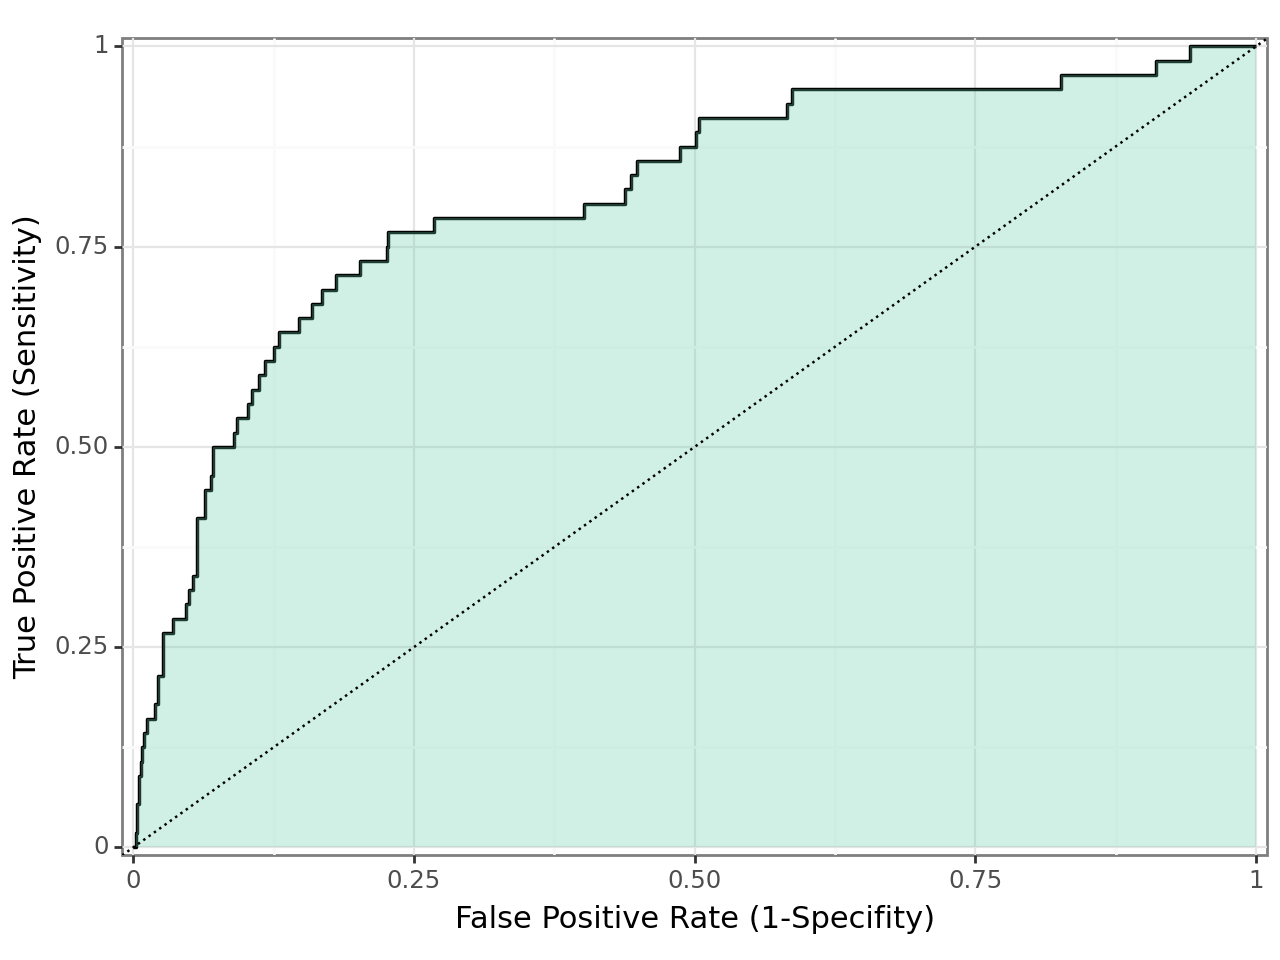

<Figure Size: (640 x 480)>

In [404]:
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

The ROC curve shows that the model is quite good, because it is well above 45 degree line. From confusion matrix we can see that the threshold is not the optimal one. Becaue all firms are classified as not default

## Finding optimal threshold

In [406]:
# Set the cost values for False Positives (FP) and False Negatives (FN)
FP = 3
FN = 15

# Calculate the cost ratio of FN to FP
cost = FN/FP  # This ratio is used to weigh the importance of FN relative to FP in cost-sensitive models

# Prevalence is the proportion of positive cases (y_train.sum()) to the total number of cases (len(y_train))
prevelance = y_train.sum()/len(y_train)
prevelance

0.10250333283957933

In [407]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold, drop_intermediate=False)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [408]:
sum(expected_loss)/len(expected_loss)

1.147093666858663

In [409]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.155653,0.157603,1.236561,1.329630
1,X2,0.122835,0.120193,1.295067,1.351852
2,X3,0.147568,0.155680,1.222786,1.302963
3,X4,0.147531,0.167311,1.147094,1.233333


The table presents the results of evaluating four logistic regression models (X1, X2, X3, X4) on their ability to predict outcomes, focusing on the determination of the optimal threshold for classification and the associated expected loss. The "Avg of optimal thresholds" column shows the average optimal threshold value for classifying observations across all folds, with X1 having the highest average threshold (0.155653) and X2 the lowest (0.122835). The "Threshold for Fold5" column reveals the optimal threshold specifically for the fifth fold of cross-validation, indicating slight variations from the overall average, which suggests model sensitivity to different data splits. "Avg expected loss" and "Expected loss for Fold5" columns quantify the average and fold-specific expected losses, respectively, with model X4 exhibiting the lowest average expected loss (1.147094) and, consequently, the lowest expected loss in the fifth fold (1.233333), highlighting its superior performance in minimizing cost-adjusted misclassifications. This suggests that model X4, despite having a higher threshold for the fifth fold compared to its overall average, manages to balance the trade-off between false positives and false negatives more effectively than the other models, underlining its potential as the most cost-efficient choice for prediction within this specific setup.

In [410]:
# choosing the best threshold
best_logit_optimal_treshold = best_thresholds_cv["X4"]
best_logit_optimal_treshold

0.14753079886870207

In [413]:
# Apply the optimal threshold to the holdout set to classify observations
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)

# Calculate the confusion matrix components: true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()

# Compute the expected loss on the holdout set using the calculated tn, fp, fn, tp, and predefined FP and FN costs
expected_loss_holdout_log1 = (fp*FP + fn*FN)/len(y_holdout)

# print the expected loss
print('Exptected loss on holdout set is:',round(expected_loss_holdout_log1, 3))

Exptected loss on holdout set is: 0.613


In [414]:
# Create a DataFrame from the confusion matrix for better visualization and understanding of the model's performance
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm3

,Predicted no default,Predicted default
Actul no defaul,909,72
Actual default,28,28


The confusion matrix provides a detailed breakdown of the model's predictions against the actual outcomes for the holdout dataset, revealing its predictive performance. With 981 firms that stayed alive and 56 that defaulted in the actual data:

- True Negatives (TN): 909 firms were correctly predicted as "no default" (stayed alive), indicating the model's ability to identify firms that would continue operating.
- False Positives (FP): 72 firms were incorrectly predicted to default ("Predicted default") when they actually stayed alive. This represents Type I error, where the model mistakenly flags firms at risk.
- False Negatives (FN): 28 firms were incorrectly predicted as "no default" when they actually defaulted. This represents Type II error, indicating missed opportunities to identify at-risk firms.
- True Positives (TP): 28 firms were correctly predicted to default, showcasing the model's capability to identify actual defaults accurately.

Given the context, the model demonstrates a balanced ability to detect both defaults and non-defaults, with an equal number of true positives and false negatives. However, the presence of false positives and false negatives highlights the model's limitations in perfectly classifying firms. The goal in predictive modeling, especially in financial contexts like default prediction, is to maximize true positives (correctly identifying defaults) while minimizing false negatives (missing defaults) due to the typically higher cost associated with failing to identify a defaulting firm. The model's performance suggests room for improvement, particularly in reducing false negatives and false positives, to enhance its predictive accuracy and reliability in identifying default risk among firms.

In [417]:
# print false positive rate
print(f'FPR: {round(cm3.iloc[0,1] / cm3.iloc[0].sum(), 3)}')
# print false negative rate
print(f'FNR: {round(cm3.iloc[1,0] / cm3.iloc[1].sum(), 3)}')
# print true positive rate
print(f'TPR: {round(cm3.iloc[1,1] / cm3.iloc[1].sum(), 3)}')

FPR: 0.073
FNR: 0.5
TPR: 0.5


## Random Forest

In [418]:
# Select the training and holdout sets for the random forest variables based on predefined indices
rfvars_train = rfvars.loc[index_train]
rfvars_holdout = rfvars.loc[index_holdout]

In [419]:
# Define a parameter grid for optimizing a tree-based model, specifying options for the number of features considered at each split,
# the criterion for the split quality, and the minimum number of samples required to split a node.
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [420]:
# Initialize a RandomForestClassifier with specific settings
prob_forest = RandomForestClassifier(
    random_state=20240303, 
    n_estimators=500,  # Specify the number of trees in the forest
    oob_score=True) 

# Set up a grid search to optimize the Random Forest parameters
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,  # Parameter grid to search through
    cv=k, 
    refit='roc_auc',  
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'],  # Scoring metrics to evaluate
    n_jobs=-1)


In [421]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

CPU times: total: 21.5 s
Wall time: 5min 15s


In [423]:
# Calculate the average cross-validation accuracy across 5 folds for the Random Forest model
cv_accuracy = np.zeros([6])  # Initialize an array to hold accuracy scores for 6 different scenarios
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']

# getting average accuracy
cv_accuracy = cv_accuracy/5  
cv_accuracy 

array([0.90475447, 0.90485318, 0.90559386, 0.90490257, 0.90598882,
       0.90544569])

In [424]:
# the same calculation for AUC
cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

array([0.82654093, 0.82580504, 0.82566706, 0.82607125, 0.82606182,
       0.82606764])

In [425]:
# the same calculation for RMSE
cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

array([0.27300076, 0.27334035, 0.27293864, 0.27305182, 0.27275012,
       0.2728679 ])

In [426]:
# put the results in a dataframe
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

# print the results
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.904754,0.826541,0.273001
1,5,16,0.904853,0.825805,0.273340
2,6,11,0.905594,0.825667,0.272939
3,6,16,0.904903,0.826071,0.273052
4,7,11,0.905989,0.826062,0.272750
5,7,16,0.905446,0.826068,0.272868


In [428]:
# find the best parameters
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']
print(f'The best random forest model has the following features: {prob_forest_fit.best_params_}')

The best random forest model has the following features: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 11}


#### Using loss function and search for finding the best thresholds and expected loss over folds

In [430]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(
        random_state=20240303, 
        n_estimators=500, 
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split)
    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)

In [431]:
best_thresholds

[0.1762019667295211,
 0.1924037060597231,
 0.18467036318776123,
 0.18243273633830906,
 0.22571352168643188]

In [434]:
# expected loss and the average of it
expected_loss, np.mean(expected_loss)

([0.9242162429029869,
  0.9597630214761788,
  1.0256726734139718,
  0.9955555555555555,
  1.0140740740740741],
 0.9838563134845535)

In [436]:
# Store the best threshold and expected loss from the last cross-validation fold
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

# Create a DataFrame summarizing the model's performance metrics at various thresholds for the last fold
all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),  
    'true_pos': true_pos_rate*sum(y_fold == 1), 
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),  
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),  
    'pos': sum(y_fold == 1),  
    'neg': sum(y_fold == 0),  
    'n': len(y_fold),  
    'thresholds': threshold 
})

# show only first 5 rows because there are too many rows
all_coords_rf.head()


,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,443.0,3607.0,443,3607,4050,inf
1,0.0,1.0,442.0,3607.0,443,3607,4050,0.754260
2,0.0,5.0,438.0,3607.0,443,3607,4050,0.711212
3,1.0,5.0,438.0,3606.0,443,3607,4050,0.705140
4,1.0,7.0,436.0,3606.0,443,3607,4050,0.702272


In [437]:
# show the last 5 rows
all_coords_rf.tail()

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
621,3177.0,441.0,2.0,430.0,443,3607,4050,0.010277
622,3177.0,442.0,1.0,430.0,443,3607,4050,0.010273
623,3212.0,442.0,1.0,395.0,443,3607,4050,0.009470
624,3212.0,443.0,0.0,395.0,443,3607,4050,0.009438
625,3607.0,443.0,0.0,0.0,443,3607,4050,0.000000


In [438]:
# average of the best thresholds and expected loss
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [439]:
# Filter the CV results DataFrame for the row matching the best parameters to identify the index of the best model's results
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [440]:
# Create a summary DataFrame for the Random Forest model's performance metrics
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(prob_forest_best_results.cv_rmse.values[0], 3)],
     'CV AUC': [round(prob_forest_best_results.cv_auc.values[0], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.273,0.827,0.192,0.226,0.984,1.014


#### Try the model on holdout set and estimate RMSE, expected loss and AUC

In [441]:
# Retrieve the best estimator from the grid search
prob_forest_fit_best = prob_forest_fit.best_estimator_

# Use the best model to predict probabilities on the holdout set
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]

# Calculate RMSE between the holdout set true values and the predicted probabilities
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))

# Print the RMSE of the Random Forest model on the holdout set
print('RMSE of Random Forest on holdout set is:', round(rmse_rf, 3))


RMSE of Random Forest on holdout set is: 0.209


We can notice that it is lower than for the best logistic model(0.214), which suggests that Random Forest model performs better than Logistic Model number 4

In [442]:
# calculating auc
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
print('AUC of Random Forest on holdout set is:', round(auc_rf, 3))

AUC of Random Forest on holdout set is: 0.86


AUC value is also higher than in logistic regression model(0.86 vs 0.813)

In [445]:
# applying optimal threshold for holdout set in Random Forest model
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout_rf1 = (fp*FP + fn*FN)/len(y_holdout)
print('Expected loss is', round(expected_loss_holdout_rf1, 3))

Expected loss is 0.616


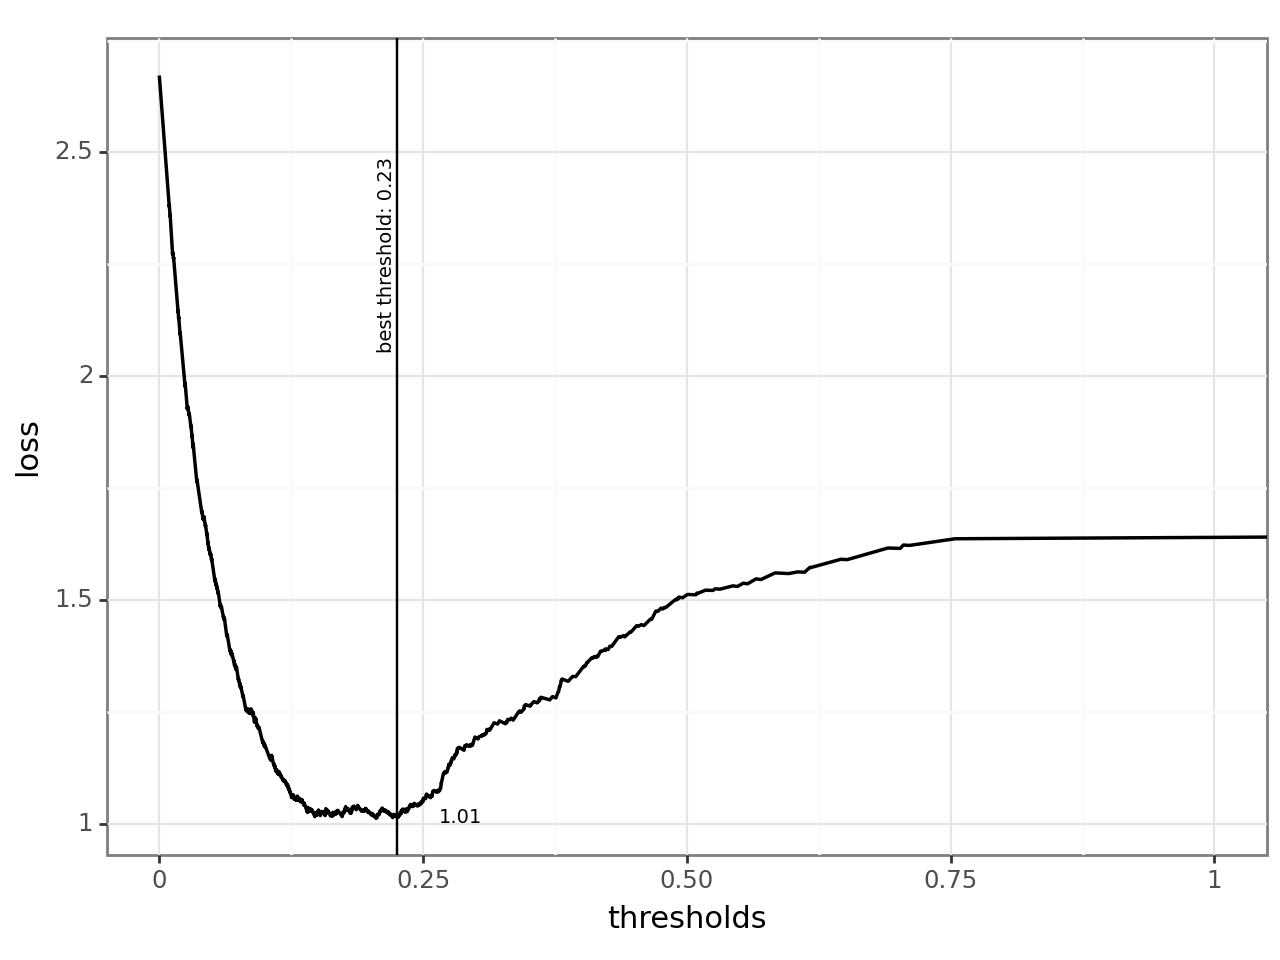

<Figure Size: (640 x 480)>

In [446]:
# creata a loss plot
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

In [448]:
# confusion matrix
cm_object4 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm4 = pd.DataFrame(cm_object4, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm4

,Predicted no default,Predicted default
Actul no defaul,898,83
Actual default,26,30


The confusion matrix for the Random Forest model shows that out of the firms predicted to not default, 898 were correctly identified (true negatives), but 26 defaults were missed (false negatives). On the other hand, of those predicted to default, 30 were accurately predicted (true positives), while 83 were incorrectly classified as defaults (false positives). This indicates a relatively strong ability of the model to identify non-defaulting firms, albeit with some room for improvement in correctly identifying actual defaults and reducing false positives.

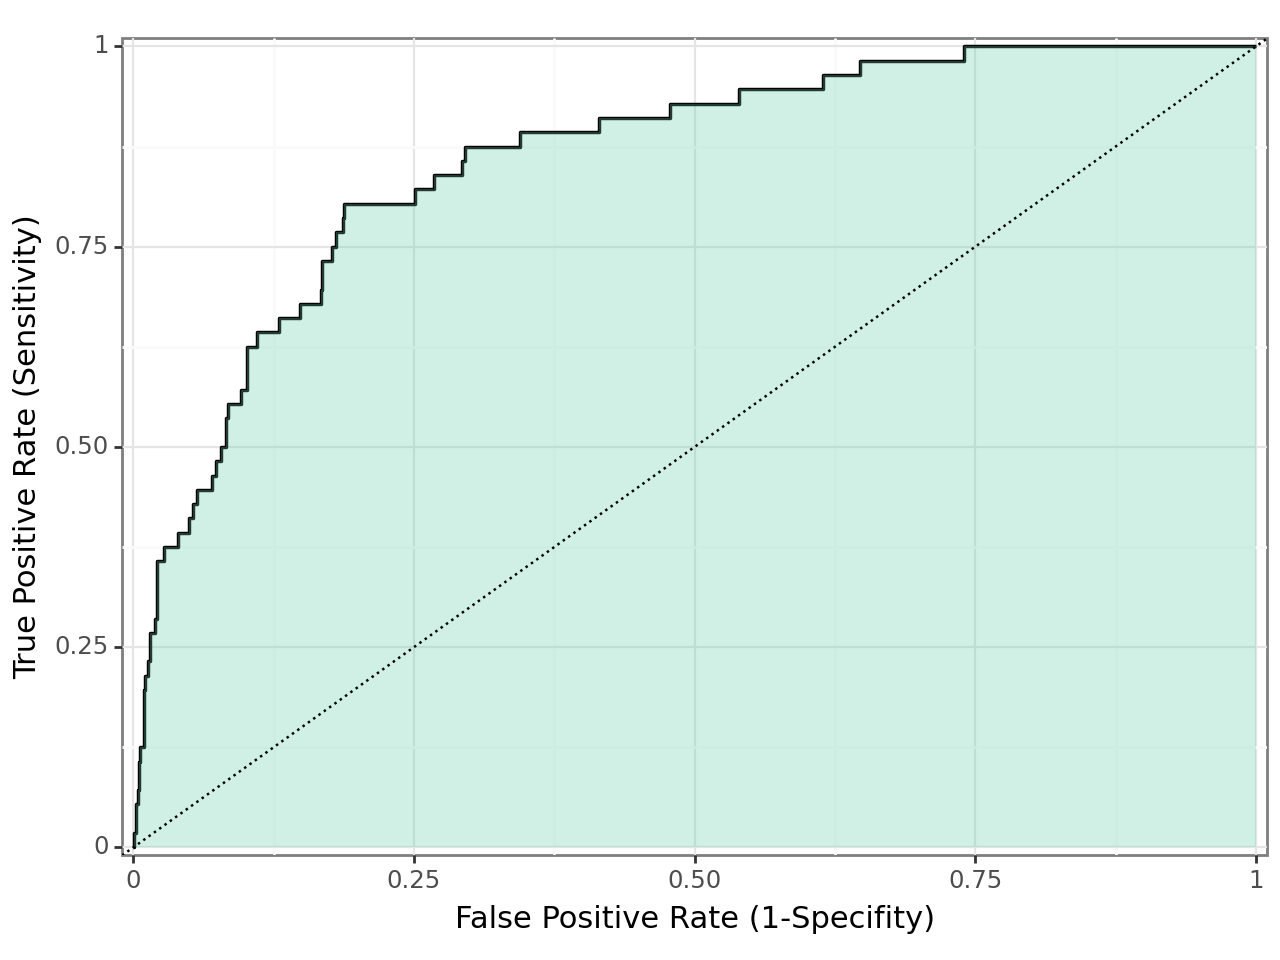

<Figure Size: (640 x 480)>

In [450]:
# roc plot
create_roc_plot(y_holdout, rf_predicted_probabilities_holdout)

Visually we can confirm that AUC value is also higher in RF than in logistic regression model(0.86 vs 0.813)

### Variable importance plot

In [463]:
# checking feature importances

pd.DataFrame(
    prob_forest_fit.best_estimator_.feature_importances_, 
    rfvars_train.columns)

df_var_imp = pd.DataFrame(
    prob_forest_fit.best_estimator_.feature_importances_, 
    rfvars_train.columns)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()
top10 = df_var_imp.head(10)
top10[['variable','imp']]

,variable,imp
0,total_assets_bs,0.039588
1,liq_assets,0.036268
2,curr_assets,0.035543
3,d1_sales_mil_log_mod,0.034444
4,share_eq,0.031895
5,liq_assets_bs,0.031369
6,curr_assets_bs,0.031095
7,fixed_assets_bs,0.030153
8,sales,0.029917
9,fixed_assets,0.029762


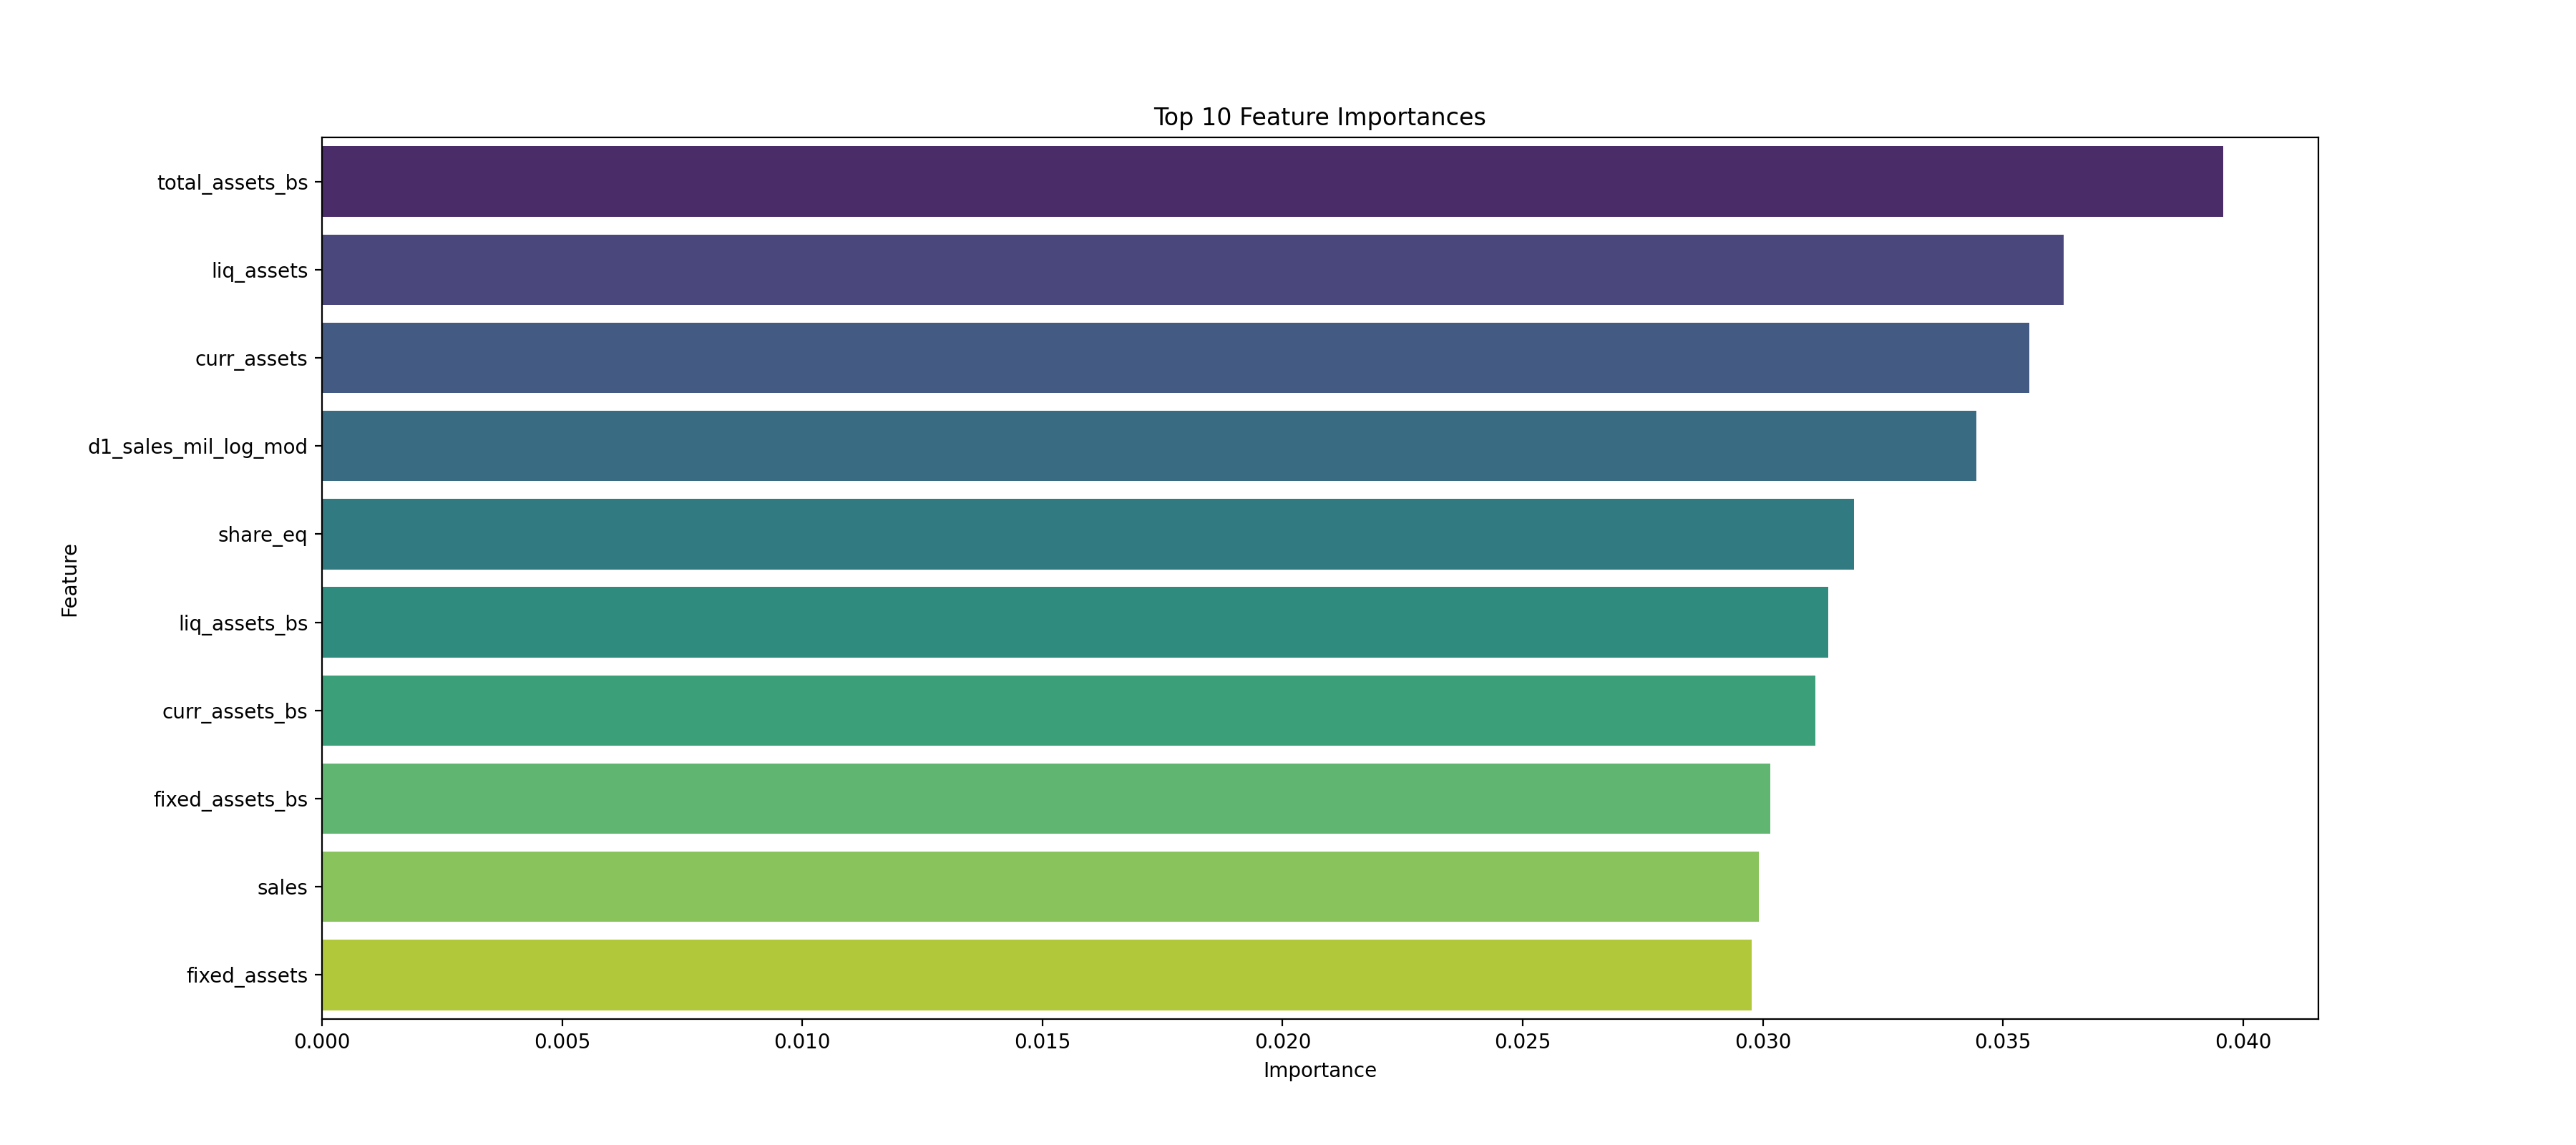

In [462]:
# plot variable importances
plt.figure(figsize=(18, 8))
sns.barplot(data=top10, x='imp', y='variable', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

 The importance score quantifies how valuable each variable is for predicting the target outcome in the model.

Balance Sheet and Liquidity Variables: The most significant variables include `total_assets_bs`, `liq_assets`, and `curr_assets`, indicating that overall asset volume and liquidity measures are critical for prediction. This suggests the model heavily relies on the firm's balance sheet strength and liquidity status to make accurate predictions.

Sales and Adjusted Sales Metrics: `d1_sales_mil_log_mod` and `sales` also appear as crucial predictors, underscoring the importance of a firm's revenue and its growth or decline rate in the model's decision-making process.

Equity and Fixed Assets: `share_eq` (shareholders' equity) and variables related to fixed assets (`fixed_assets_bs` and `fixed_assets`) are also highlighted as important, suggesting that the model considers the firm's equity base and the value of its long-term assets significant in predicting the outcome.

Let's plot some partial dependance plots to understand the relationship between default parameter and the couple of top 10 variables

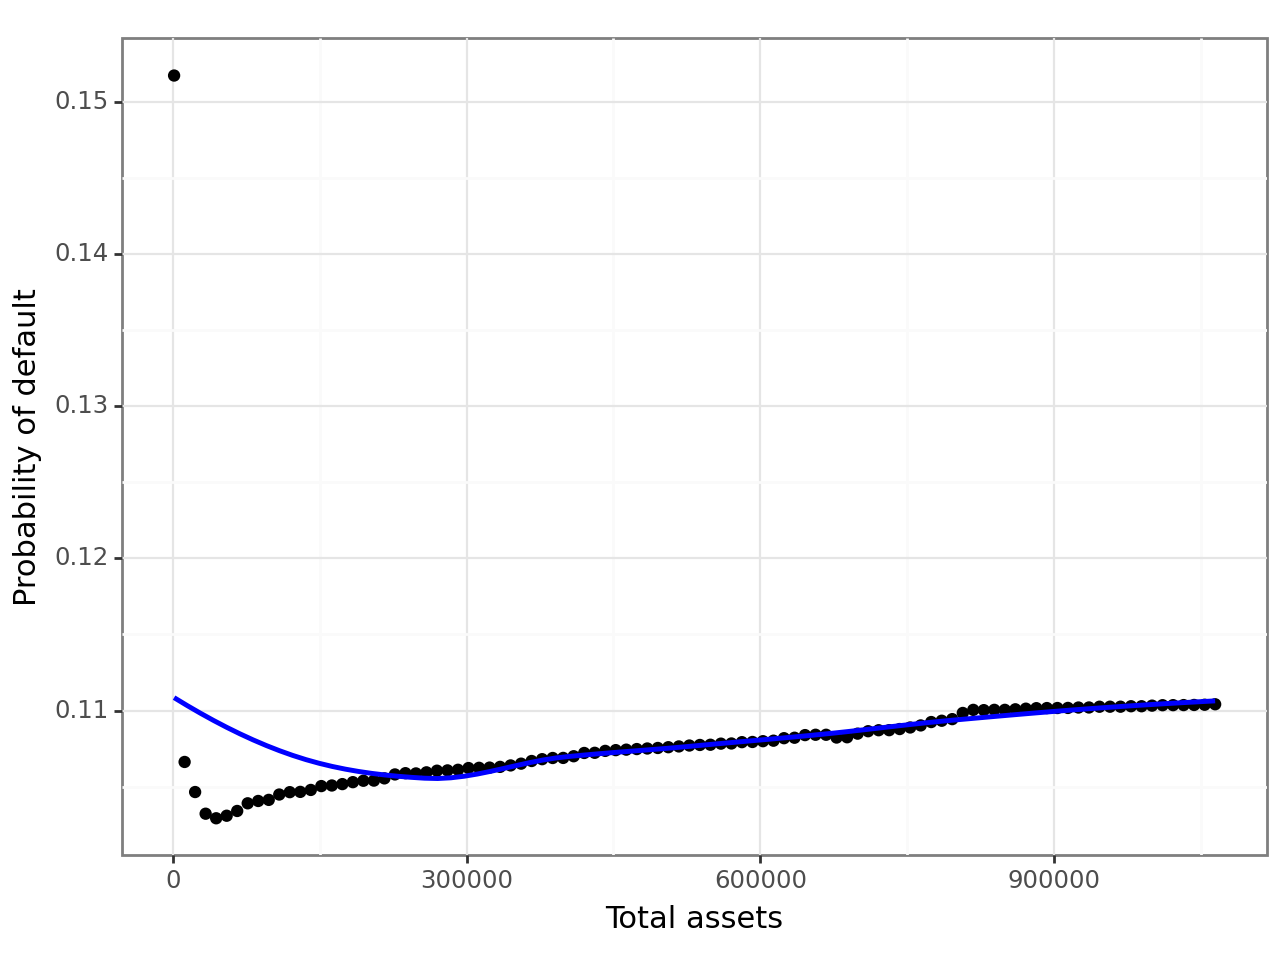

In [469]:
# Generate partial dependence data
pdp_total_assets_bs = partial_dependence(prob_forest_fit, rfvars, ["total_assets_bs"], kind="average")

# Prepare DataFrame for plotting
pdp_df = pd.DataFrame({
    'Total assets': pdp_total_assets_bs['values'][0].flatten(), 
    'Probability of default': pdp_total_assets_bs['average'][0].flatten()
})

# Plot the partial dependence plot
plot = ggplot(pdp_df, aes(x='Total assets', y='Probability of default')) + \
    geom_point() + theme_bw() + geom_smooth(method='loess', se=False, color='blue')

print(plot)

From the plot, we observe that as total assets increase from 0, there is an initial sharp decline in the probability of default. This suggests that firms with very few assets are much more likely to default. However, as assets continue to increase, the probability of default begins to level out. The trend becomes relatively flat for higher asset values, indicating that increases in total assets beyond a certain point have a negligible impact on reducing the probability of default. This could imply that once a firm has reached a threshold of asset accumulation, other factors may play a more significant role in the default risk, or that the firm's asset size is sufficient to not significantly affect the default risk further.

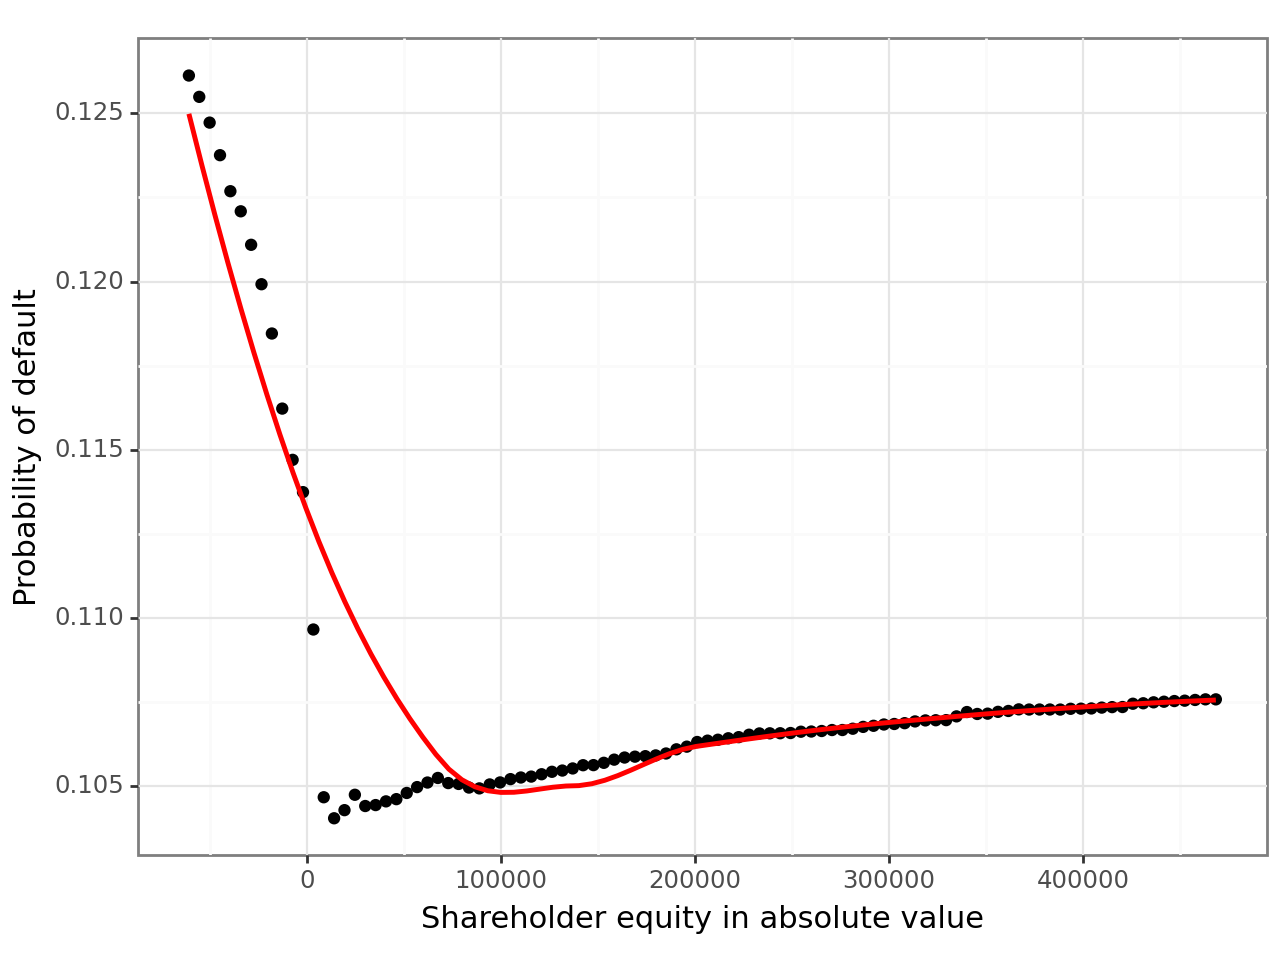

<Figure Size: (640 x 480)>

In [468]:
# share_eq
pdp_share_eq = partial_dependence(
    prob_forest_fit, rfvars, ["share_eq"], kind="average"
)

pdp_share_eq = pd.DataFrame(
    {'Shareholder equity in absolute value': pdp_share_eq['values'][0], 
     'Probability of default': pdp_share_eq['average'][0]}
    )

# plot the partial dependence plot
ggplot(pdp_share_eq, aes(x='Shareholder equity in absolute value', y='Probability of default')) + \
    geom_point() + theme_bw() + geom_smooth(method='loess', se=False, color='red')

From the plot, we can observe that as shareholder equity increases from zero, the probability of default sharply decreases initially, suggesting that firms with very low equity are at a higher risk of default. However, beyond a certain point, increases in shareholder equity have a diminishing effect on reducing default probability. For higher values of shareholder equity, the probability of default seems to level off, indicating that additional equity above this point does not significantly alter the default risk as assessed by the model. This plateau effect suggests that other factors might become more influential in predicting default risk once a firm has an adequate equity buffer.

## Conclusion

In [ ]:
# show confusion matrix for random forest
cm4
# show confusion matrix for logistic regression
cm3